### 1. Persiapan Awal (Setup)

In [102]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap
import warnings
warnings.filterwarnings('ignore')

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
plt.style.use('default')
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Improved save_fig function
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    print(f"Saving figure: {fig_id}")
    if tight_layout:
        plt.tight_layout()
    plt.show()  # This will display the plot

### 2. Voting Classifiers
Gunakan dataset "moons":

Training set size: 375
Test set size: 125


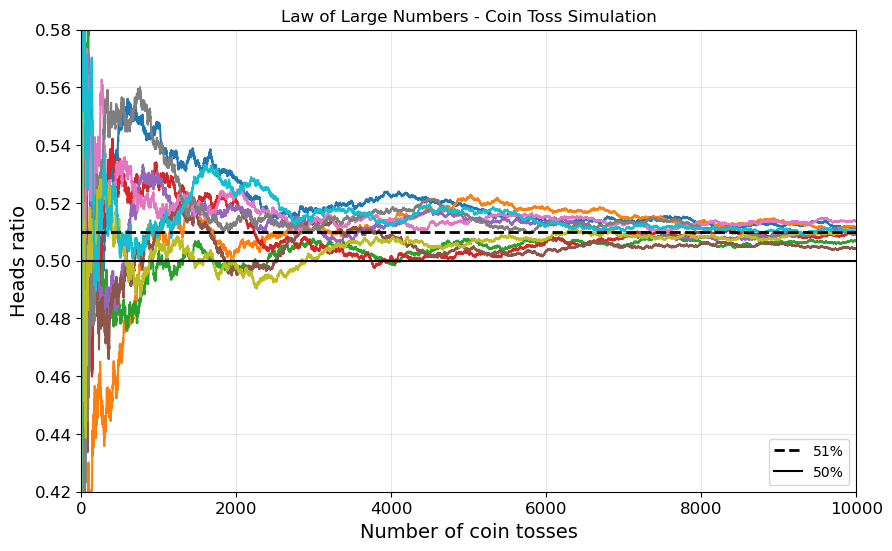

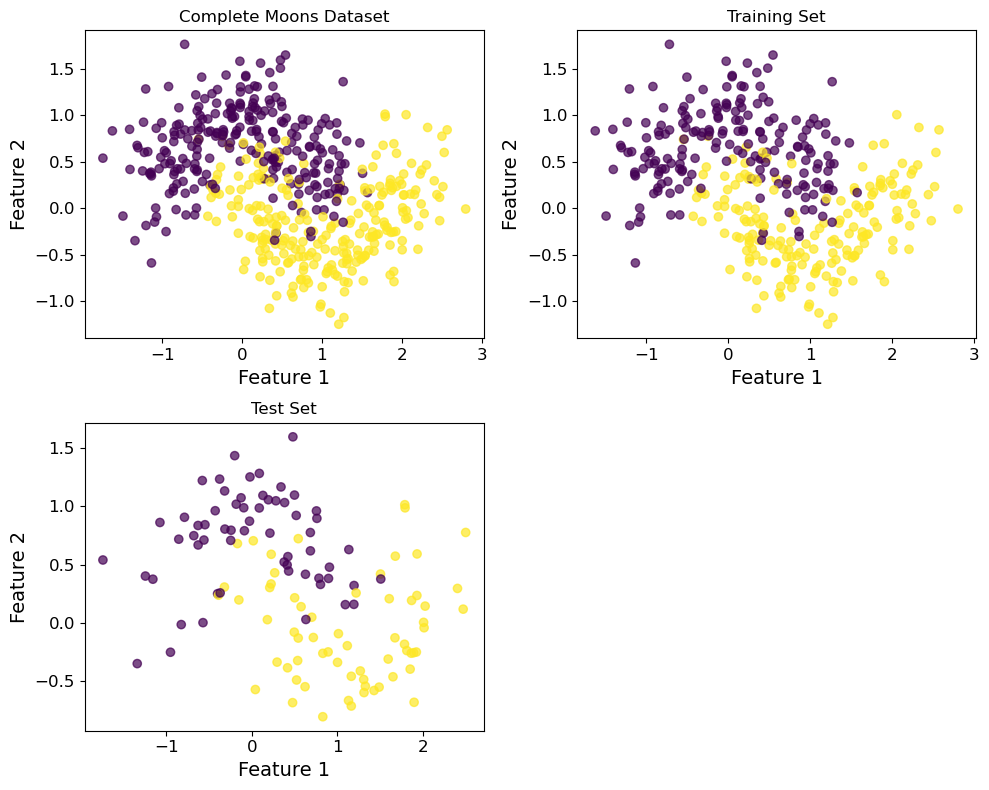

In [103]:
# Demonstrate law of large numbers
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

# Plot law of large numbers
plt.figure(figsize=(10, 6))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
plt.title("Law of Large Numbers - Coin Toss Simulation")
plt.grid(True, alpha=0.3)

# Create moons dataset
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# Visualize the moons dataset
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.title("Complete Moons Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

plt.subplot(2, 2, 2)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', alpha=0.7)
plt.title("Training Set")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

plt.subplot(2, 2, 3)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='viridis', alpha=0.7)
plt.title("Test Set")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

plt.tight_layout()
plt.show()

In [104]:
# Create individual classifiers
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

##### Hard Voting

In [105]:
# Hard voting classifier
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard'
)

In [106]:
print("\n=== HARD VOTING RESULTS ===")
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{clf.__class__.__name__}: {accuracy:.4f}")


=== HARD VOTING RESULTS ===
LogisticRegression: 0.8640
RandomForestClassifier: 0.8960
SVC: 0.8960
VotingClassifier: 0.9120


##### Soft voting:

In [107]:
# Soft voting classifier
log_clf_soft = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf_soft = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf_soft = SVC(gamma="scale", probability=True, random_state=42)

voting_clf_soft = VotingClassifier(
    estimators=[('lr', log_clf_soft), ('rf', rnd_clf_soft), ('svc', svm_clf_soft)],
    voting='soft'
)

In [108]:
print("\n=== SOFT VOTING RESULTS ===")
for clf in (log_clf_soft, rnd_clf_soft, svm_clf_soft, voting_clf_soft):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{clf.__class__.__name__}: {accuracy:.4f}")


=== SOFT VOTING RESULTS ===
LogisticRegression: 0.8640


RandomForestClassifier: 0.8960
SVC: 0.8960
VotingClassifier: 0.9200


### 3. Bagging dan Pasting
#### Bagging dan Pasting di Scikit-Learn

In [109]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Bagging classifier
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42
)
bag_clf.fit(X_train, y_train)
y_pred_bag = bag_clf.predict(X_test)

# Single decision tree for comparison
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)

In [110]:
print(f"\n=== BAGGING VS SINGLE TREE ===")
print(f"Single Decision Tree Accuracy: {accuracy_score(y_test, y_pred_tree):.4f}")
print(f"Bagging Ensemble Accuracy: {accuracy_score(y_test, y_pred_bag):.4f}")


=== BAGGING VS SINGLE TREE ===
Single Decision Tree Accuracy: 0.8560
Bagging Ensemble Accuracy: 0.9040


Text(0, 0.5, '')

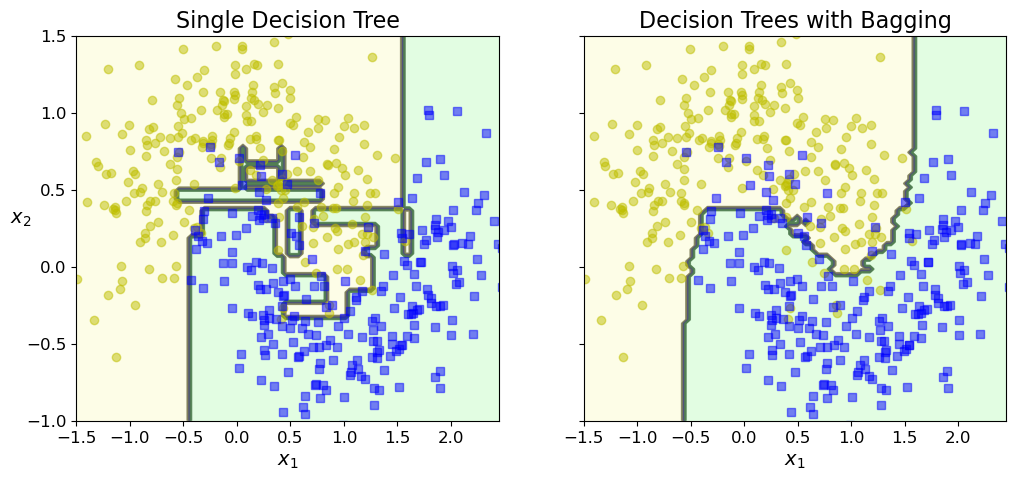

In [111]:
# Improved decision boundary plotting function
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha, markersize=6)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha, markersize=6)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=14)
    plt.ylabel(r"$x_2$", fontsize=14, rotation=0)

# Plot decision boundaries comparison
fig, axes = plt.subplots(ncols=2, figsize=(12, 5), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Single Decision Tree", fontsize=16)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=16)
plt.ylabel("")

#### Evaluasi Out-of-Bag

In [112]:
# Out-of-bag evaluation
bag_clf_oob = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40
)
bag_clf_oob.fit(X_train, y_train)

print(f"\n=== OUT-OF-BAG EVALUATION ===")
print(f"OOB Score: {bag_clf_oob.oob_score_:.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, bag_clf_oob.predict(X_test)):.4f}")
print(f"OOB Decision Function Shape: {bag_clf_oob.oob_decision_function_.shape}")


=== OUT-OF-BAG EVALUATION ===
OOB Score: 0.8987
Test Accuracy: 0.9120
OOB Decision Function Shape: (375, 2)


### 4. Random Forests

In [113]:
# Random Forest classifier
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

print(f"\n=== RANDOM FOREST RESULTS ===")
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")


=== RANDOM FOREST RESULTS ===
Random Forest Accuracy: 0.9120


In [114]:
# Compare with equivalent bagging classifier
bag_clf_equiv = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, random_state=42
)
bag_clf_equiv.fit(X_train, y_train)
y_pred_equiv = bag_clf_equiv.predict(X_test)

print(f"Equivalent Bagging Accuracy: {accuracy_score(y_test, y_pred_equiv):.4f}")
print(f"Prediction similarity: {np.sum(y_pred_rf == y_pred_equiv) / len(y_pred_rf):.4f}")

Equivalent Bagging Accuracy: 0.9120
Prediction similarity: 1.0000


In [115]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [116]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # prediksi yang sangat mirip

np.float64(0.976)

### 5. Pentingnya Fitur (Feature Importance)

In [117]:
# Feature importance with Iris dataset
from sklearn.datasets import load_iris

iris = load_iris()
rnd_clf_iris = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf_iris.fit(iris["data"], iris["target"])

print(f"\n=== IRIS FEATURE IMPORTANCE ===")
for name, score in zip(iris["feature_names"], rnd_clf_iris.feature_importances_):
    print(f"{name}: {score:.4f}")


=== IRIS FEATURE IMPORTANCE ===
sepal length (cm): 0.1125
sepal width (cm): 0.0231
petal length (cm): 0.4410
petal width (cm): 0.4234


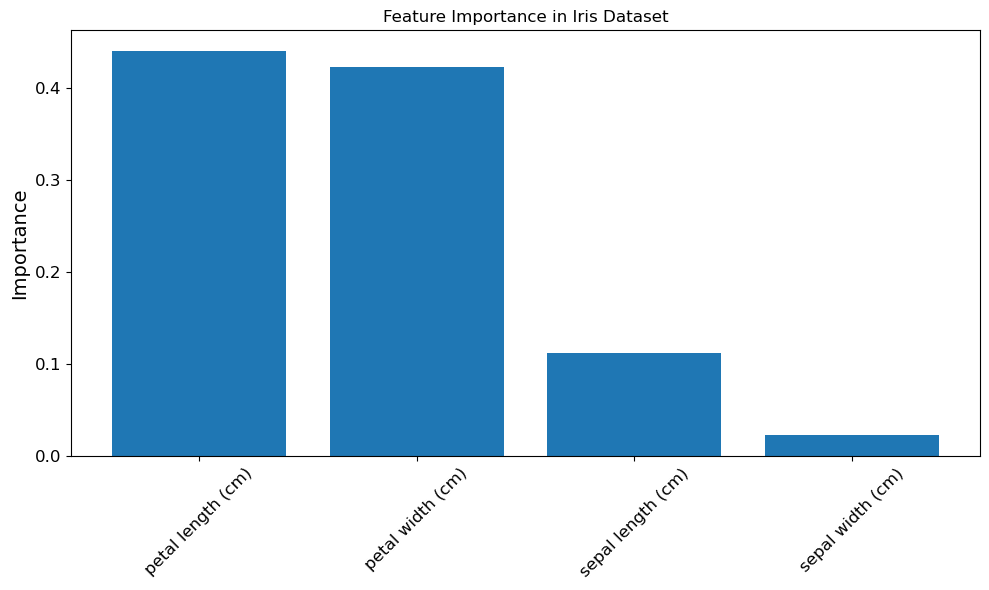

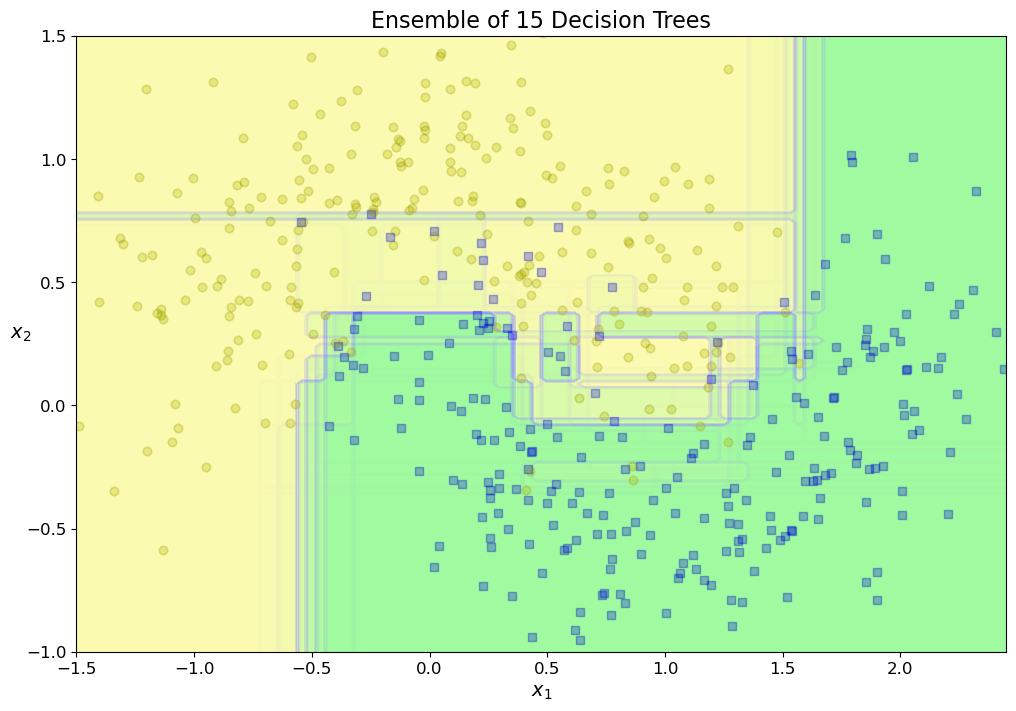

In [118]:
# Visualize feature importance
plt.figure(figsize=(10, 6))
feature_names = iris["feature_names"]
importances = rnd_clf_iris.feature_importances_
indices = np.argsort(importances)[::-1]

plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45)
plt.title("Feature Importance in Iris Dataset")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

# Visualize ensemble of decision trees
plt.figure(figsize=(12, 8))
for i in range(15):
    tree_clf_sample = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf_sample.fit(X_train[indices_with_replacement], y_train[indices_with_replacement])
    plot_decision_boundary(tree_clf_sample, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.02, contour=False)

plt.title("Ensemble of 15 Decision Trees", fontsize=16)
plt.show()

In [119]:
print("\n=== LOADING MNIST DATA ===")
from sklearn.datasets import fetch_openml
# Use a smaller subset for demonstration
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)


=== LOADING MNIST DATA ===


In [120]:
# Use only first 10000 samples for faster computation
X_mnist = mnist.data[:10000]
y_mnist = mnist.target[:10000]

print(f"MNIST data shape: {X_mnist.shape}")
print(f"MNIST target shape: {y_mnist.shape}")

rnd_clf_mnist = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf_mnist.fit(X_mnist, y_mnist)

MNIST data shape: (10000, 784)
MNIST target shape: (10000,)


RandomForestClassifier(random_state=42)

Text(0.5, 1.0, 'MNIST Pixel Importance (Random Forest)')

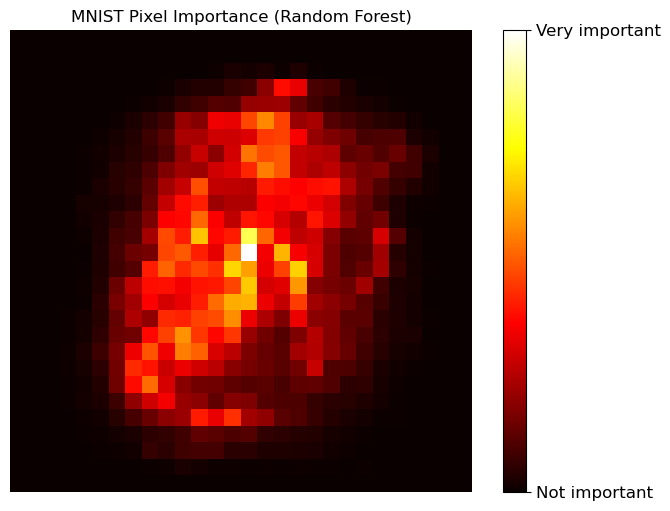

In [121]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=mpl.cm.hot, interpolation="nearest")
    plt.axis("off")

plt.figure(figsize=(8, 6))
plot_digit(rnd_clf_mnist.feature_importances_)
cbar = plt.colorbar(ticks=[rnd_clf_mnist.feature_importances_.min(), 
                            rnd_clf_mnist.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])
plt.title("MNIST Pixel Importance (Random Forest)")

### 6. Boosting
#### AdaBoost


=== ADABOOST RESULTS ===
AdaBoost Accuracy: 0.8960
Saving figure: adaboost_decision_boundary


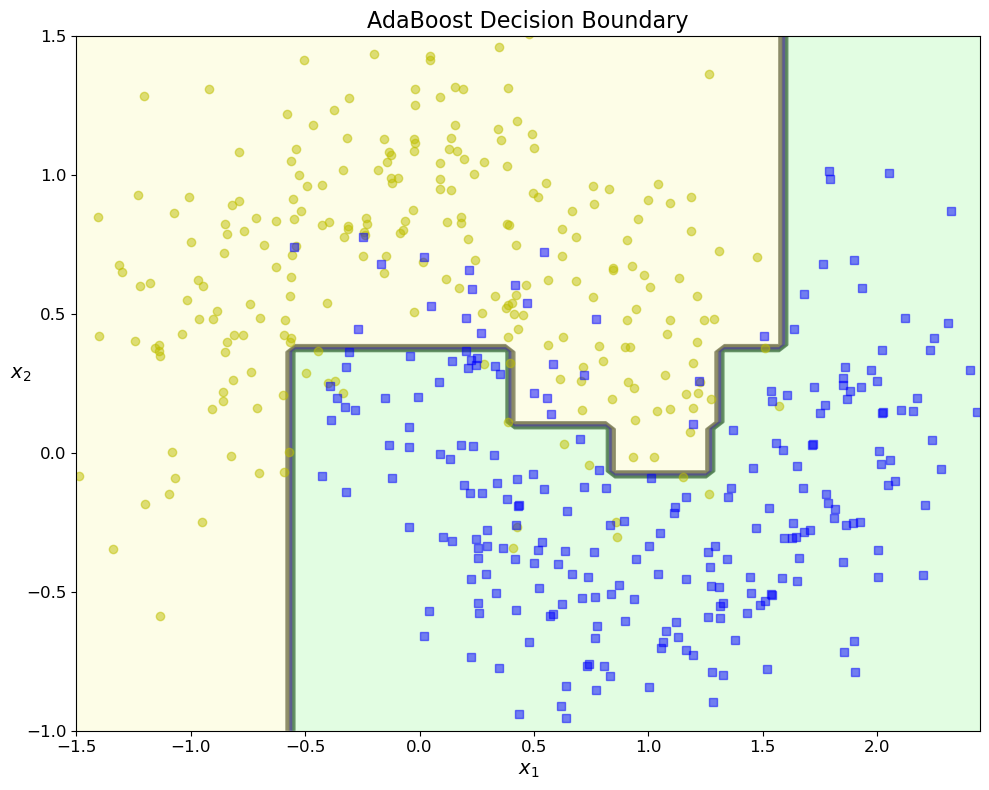

In [144]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME", learning_rate=0.5, random_state=42
)
ada_clf.fit(X_train, y_train)

print(f"\n=== ADABOOST RESULTS ===")
print(f"AdaBoost Accuracy: {accuracy_score(y_test, ada_clf.predict(X_test)):.4f}")

# Plot AdaBoost decision boundary
plt.figure(figsize=(10, 8))
plot_decision_boundary(ada_clf, X, y)
plt.title("AdaBoost Decision Boundary", fontsize=16)
save_fig("adaboost_decision_boundary")

#### Gradient Boosting

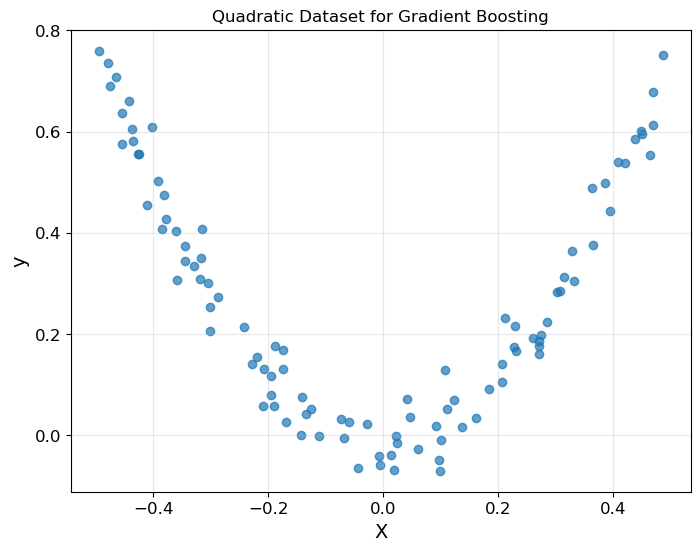

In [123]:
# Create quadratic dataset for regression
np.random.seed(42)
X_reg = np.random.rand(100, 1) - 0.5
y_reg = 3*X_reg[:, 0]**2 + 0.05 * np.random.randn(100)

# Visualize the dataset
plt.figure(figsize=(8, 6))
plt.scatter(X_reg[:, 0], y_reg, alpha=0.7)
plt.xlabel("X")
plt.ylabel("y")
plt.title("Quadratic Dataset for Gradient Boosting")
plt.grid(True, alpha=0.3)
plt.show()

##### Latih decision tree regressor pada dataset ini:

In [124]:
# Manual gradient boosting implementation
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X_reg, y_reg)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [125]:
y2 = y_reg - tree_reg1.predict(X_reg)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X_reg, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [126]:
y3 = y2 - tree_reg2.predict(X_reg)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X_reg, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [127]:
X_new = np.array([[0.8]])
y_pred_manual = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [128]:
print(f"\n=== MANUAL GRADIENT BOOSTING ===")
print(f"Prediction for X=0.8: {y_pred_manual[0]:.4f}")

# Plotting function for predictions
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label, markersize=6)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=12)
    plt.axis(axes)


=== MANUAL GRADIENT BOOSTING ===
Prediction for X=0.8: 0.7503


Saving figure: gradient_boosting_plot


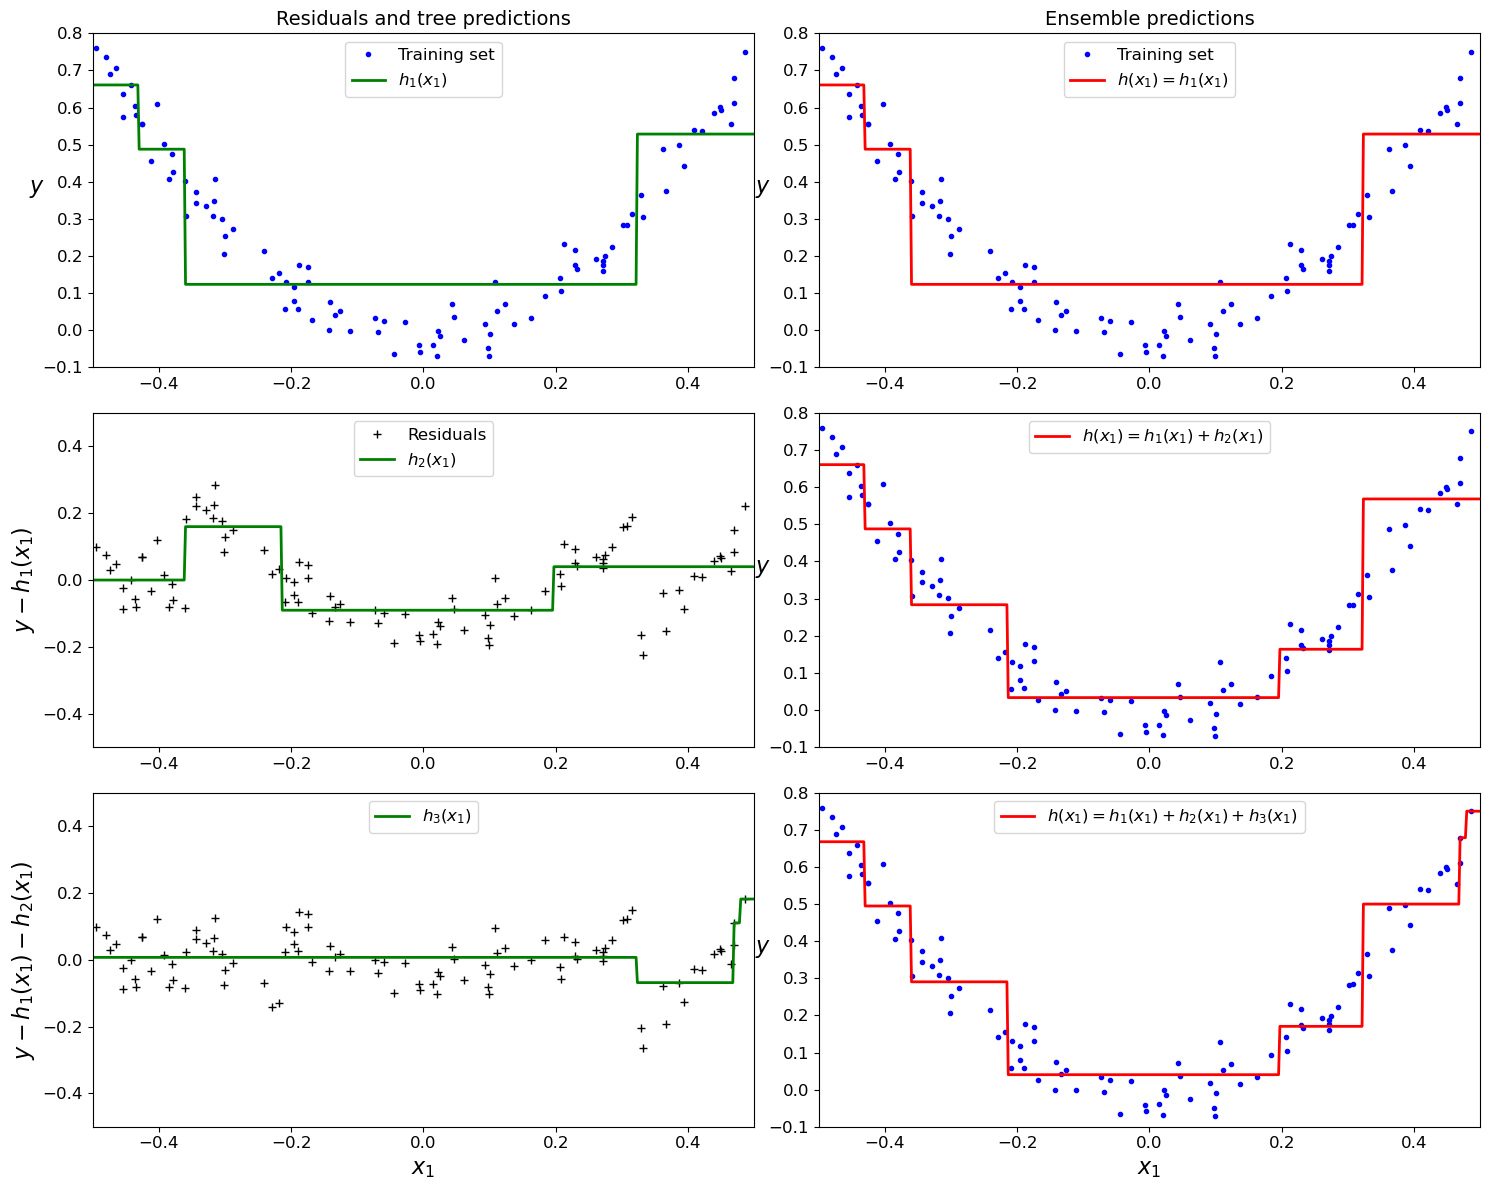

In [129]:
# Plot gradient boosting steps
plt.figure(figsize=(15, 12))

plt.subplot(321)
plot_predictions([tree_reg1], X_reg, y_reg, axes=[-0.5, 0.5, -0.1, 0.8], 
                label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=14)

plt.subplot(322)
plot_predictions([tree_reg1], X_reg, y_reg, axes=[-0.5, 0.5, -0.1, 0.8], 
                label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=14)

plt.subplot(323)
plot_predictions([tree_reg2], X_reg, y2, axes=[-0.5, 0.5, -0.5, 0.5], 
                label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X_reg, y_reg, axes=[-0.5, 0.5, -0.1, 0.8], 
                label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X_reg, y3, axes=[-0.5, 0.5, -0.5, 0.5], 
                label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X_reg, y_reg, axes=[-0.5, 0.5, -0.1, 0.8], 
                label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

save_fig("gradient_boosting_plot")

##### Coba gradient boosting regressor:

In [130]:
# Scikit-learn Gradient Boosting Regressor
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X_reg, y_reg)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [131]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X_reg, y_reg)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)


=== GRADIENT BOOSTING REGRESSOR ===
GBRT (3 estimators, lr=1.0) prediction for X=0.8: 0.7503
GBRT (200 estimators, lr=0.1) prediction for X=0.8: 0.7440
Saving figure: gbrt_learning_rate_plot


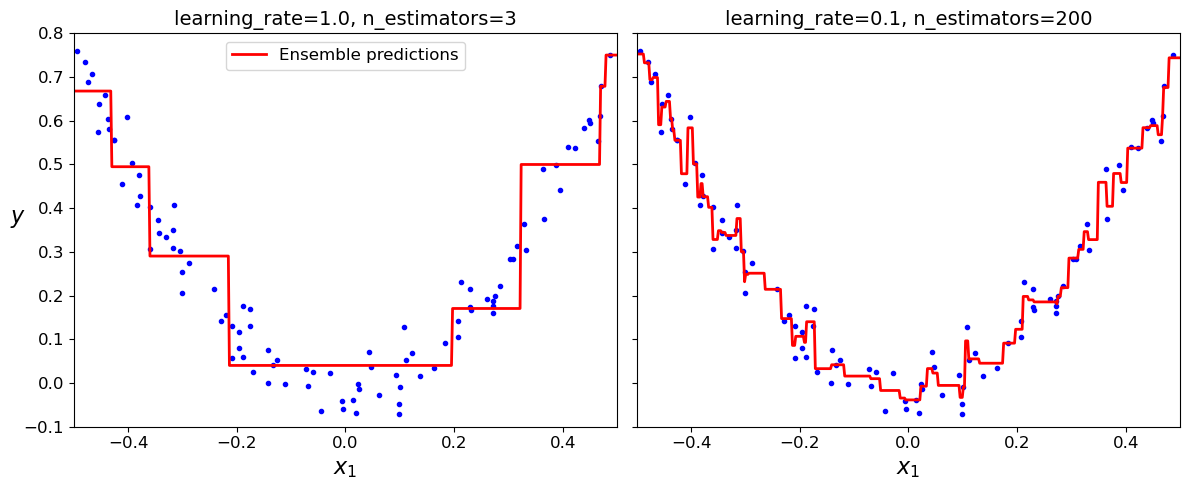

In [132]:
print(f"\n=== GRADIENT BOOSTING REGRESSOR ===")
print(f"GBRT (3 estimators, lr=1.0) prediction for X=0.8: {gbrt.predict([[0.8]])[0]:.4f}")
print(f"GBRT (200 estimators, lr=0.1) prediction for X=0.8: {gbrt_slow.predict([[0.8]])[0]:.4f}")

# Plot learning rate comparison
fig, axes = plt.subplots(ncols=2, figsize=(12, 5), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X_reg, y_reg, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title(f"learning_rate={gbrt.learning_rate}, n_estimators={gbrt.n_estimators}", fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X_reg, y_reg, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title(f"learning_rate={gbrt_slow.learning_rate}, n_estimators={gbrt_slow.n_estimators}", fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

save_fig("gbrt_learning_rate_plot")

##### Gradient Boosting dengan Early stopping:

In [133]:
# Early stopping example
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train_reg, X_val_reg, y_train_reg, y_val_reg = train_test_split(X_reg, y_reg, random_state=49)

gbrt_early = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt_early.fit(X_train_reg, y_train_reg)

errors = [mean_squared_error(y_val_reg, y_pred)
          for y_pred in gbrt_early.staged_predict(X_val_reg)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train_reg, y_train_reg)

GradientBoostingRegressor(max_depth=2, n_estimators=np.int64(56),
                          random_state=42)

Saving figure: early_stopping_gbrt_plot


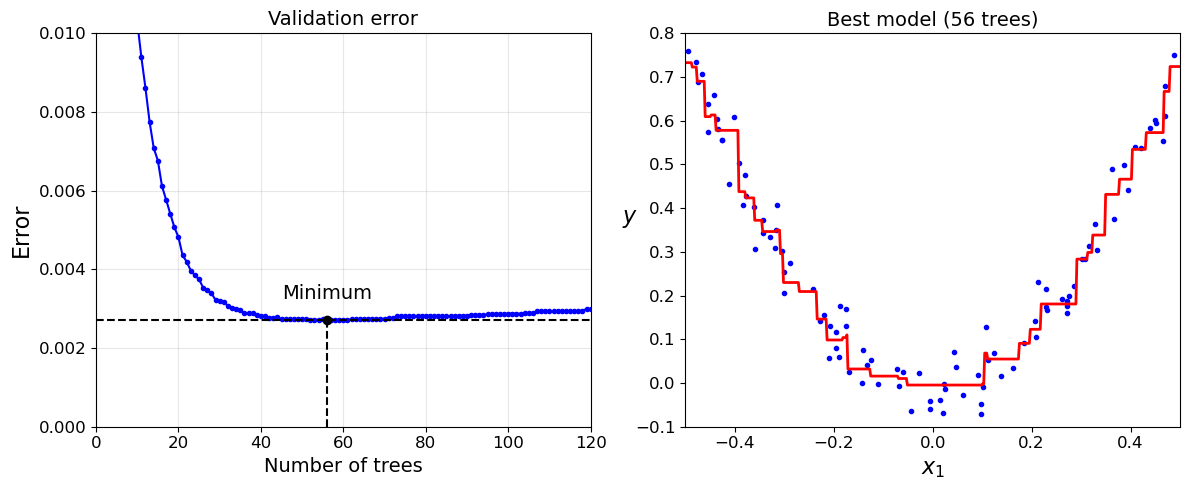

In [134]:
# Plot early stopping
min_error = np.min(errors)

plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.plot(np.arange(1, len(errors) + 1), errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)
plt.grid(True, alpha=0.3)

plt.subplot(122)
plot_predictions([gbrt_best], X_reg, y_reg, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title(f"Best model ({bst_n_estimators} trees)", fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

save_fig("early_stopping_gbrt_plot")

Early stopping dengan sedikit kesabaran (menghentikan pelatihan hanya setelah tidak ada perbaikan selama 5 epochs):

In [135]:
# Early stopping with patience
gbrt_patience = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt_patience.n_estimators = n_estimators
    gbrt_patience.fit(X_train_reg, y_train_reg)
    y_pred = gbrt_patience.predict(X_val_reg)
    val_error = mean_squared_error(y_val_reg, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [136]:
print(f"\n=== EARLY STOPPING WITH PATIENCE ===")
print(f"Stopped at {gbrt_patience.n_estimators} estimators")
print(f"Minimum validation MSE: {min_val_error:.6f}")


=== EARLY STOPPING WITH PATIENCE ===
Stopped at 61 estimators
Minimum validation MSE: 0.002713


#### Menggunakan XGBoost:

In [137]:
try:
    import xgboost
except ImportError as ex:
    print("Error: the xgboost library is not installed.")
    xgboost = None

In [140]:
xgb_reg = xgboost.XGBRegressor(random_state=42)
xgb_reg.fit(X_train_reg, y_train_reg)
y_pred_xgb = xgb_reg.predict(X_val_reg)
val_error_xgb = mean_squared_error(y_val_reg, y_pred_xgb)
print(f"XGBoost Validation MSE: {val_error_xgb:.6f}")

# XGBoost with early stopping
xgb_reg_early = xgboost.XGBRegressor(random_state=42)
xgb_reg_early.fit(X_train_reg, y_train_reg,
                    eval_set=[(X_val_reg, y_val_reg)],
                    verbose=False)
y_pred_xgb_early = xgb_reg_early.predict(X_val_reg)
val_error_xgb_early = mean_squared_error(y_val_reg, y_pred_xgb_early)
print(f"XGBoost with Early Stopping Validation MSE: {val_error_xgb_early:.6f}")

XGBoost Validation MSE: 0.004644
XGBoost with Early Stopping Validation MSE: 0.004644


In [141]:
%timeit xgboost.XGBRegressor().fit(X_train, y_train) if xgboost is not None else None

112 ms ± 38.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [142]:
%timeit GradientBoostingRegressor().fit(X_train, y_train)

74.2 ms ± 1.96 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


---

# Analisis Ensemble Learning pada Dataset "Moons" dan Iris

## Pengantar
Eksperimen ini dilakukan untuk mengevaluasi performa berbagai teknik **ensemble learning** menggunakan dataset **"moons"** dan **Iris**. Hasil menunjukkan bagaimana kombinasi model dapat meningkatkan akurasi dibandingkan penggunaan model individu.

## 1. Voting Classifiers
Pada bagian ini, kinerja tiga pengklasifikasi dasar dibandingkan:
- **Logistic Regression**
- **Random Forest Classifier**
- **Support Vector Classifier (SVC)**

### Hasil Hard Voting
| Model                  | Akurasi  |
|------------------------|----------|
| Logistic Regression   | 0.8640   |
| Random Forest        | 0.8960   |
| SVC                  | 0.8960   |
| **VotingClassifier (Hard Voting)** | **0.9120** |

### Hasil Soft Voting
| Model                  | Akurasi  |
|------------------------|----------|
| Logistic Regression   | 0.8640   |
| Random Forest        | 0.8960   |
| SVC (probability=True) | 0.8960   |
| **VotingClassifier (Soft Voting)** | **0.9200** |

### Kesimpulan
**Voting Classifier** secara konsisten mengungguli kinerja masing-masing pengklasifikasi individu. Soft voting menunjukkan peningkatan akurasi dibandingkan hard voting (**0.9200 vs 0.9120**), karena mempertimbangkan probabilitas prediksi untuk keputusan akhir ensemble.

## 2. Bagging dan Pasting
Evaluasi **BaggingClassifier** dibandingkan dengan **DecisionTreeClassifier** tunggal.

### Hasil Perbandingan
| Model | Akurasi |
|-------|---------|
| Decision Tree | 0.8560 |
| Bagging Ensemble | **0.9040** |

### Evaluasi Out-of-Bag (OOB)
| Metode | Skor |
|--------|------|
| Out-of-Bag Score | 0.8987 |
| Akurasi Test Set | **0.9120** |

### Kesimpulan
Bagging secara signifikan meningkatkan akurasi dibandingkan **Decision Tree tunggal** (**0.9040 vs 0.8560**), mengurangi variance dan mencegah overfitting. Validasi **OOB** memberikan estimasi kinerja yang akurat tanpa perlu membagi dataset secara eksplisit.

## 3. Random Forests
**Random Forest** adalah bentuk khusus dari Bagging dengan pemilihan fitur yang acak.

### Hasil Perbandingan
| Model | Akurasi |
|--------|---------|
| Random Forest | **0.9120** |
| Bagging Classifier Ekuivalen | **0.9120** |

### Kesimpulan
Random Forest mencapai akurasi tinggi yang **identik** dengan BaggingClassifier yang dikonfigurasi serupa, menunjukkan bahwa **Random Forest adalah bentuk optimal dari Bagging**.

## 4. Pentingnya Fitur (Feature Importance)
Evaluasi **Random Forest** pada dataset **Iris** untuk melihat kepentingan fitur.

| Fitur | Importance |
|--------|------------|
| Panjang Sepal (cm) | 0.1125 |
| Lebar Sepal (cm) | 0.0231 |
| Panjang Petal (cm) | **0.4410** |
| Lebar Petal (cm) | **0.4234** |

### Kesimpulan
Fitur **panjang petal** dan **lebar petal** adalah fitur paling berpengaruh dalam klasifikasi spesies bunga Iris.

## 5. Boosting (AdaBoost dan Gradient Boosting)
Boosting melatih model secara sekuensial, memperbaiki kesalahan dari model sebelumnya.

### Hasil AdaBoost & Gradient Boosting
| Metode | Skor |
|--------|------|
| AdaBoost Accuracy | 0.8960 |
| Manual Gradient Boosting | 0.7503 |
| Prediksi Ensemble (3 pohon) | 0.7503 |
| Prediksi Ensemble (200 pohon) | 0.7440 |
| MSE Validasi Gradient Boosting dengan Early stopping | 0.002713 |
| MSE Validasi XGBoost | 0.004644 |
| MSE Validasi XGBoost (Early Stopping) | 0.004644 |

### Perbandingan Waktu Pelatihan
| Model | Waktu Pelatihan |
|--------|----------------|
| **XGBRegressor** | 112 ms per loop |
| GradientBoostingRegressor (Scikit-Learn) | 74.2 ms per loop |

### Kesimpulan
- **AdaBoost** meningkatkan akurasi dengan fokus pada sampel yang sulit diklasifikasikan.
- **Gradient Boosting** menunjukkan bagaimana model belajar dari kesalahan sebelumnya.
- **Early stopping** penting untuk mencegah overfitting.
- **XGBoost** lebih cepat dibandingkan GradientBoostingRegressor dalam pelatihan.

## Kesimpulan Umum
Eksperimen ini menunjukkan **kekuatan ensemble learning**:
- **Bagging & Random Forests** mengurangi variance dan meningkatkan stabilitas model.
- **Boosting** mengurangi bias dan meningkatkan akurasi secara bertahap.
- **Validasi OOB** menyediakan estimasi kinerja yang akurat tanpa memisahkan dataset.
- **Feature Importance** memberikan wawasan tentang fitur yang paling berpengaruh.

Ensemble learning adalah pendekatan **efektif** dalam **menggabungkan kekuatan banyak model** untuk memperoleh **prediksi yang lebih akurat** dan **robust**.
